In [32]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers

In [35]:
#loading data
DDataFile = './data/processed_features_U50K_100K_200K/D_VLOS_scaled_mean_mean_alpha6_fft_abs_Frobenius_sphericalWave_B32_U50000.mat'
DData = sio.loadmat(DDataFile)

LocationDataFile = './data/randLocationU50000VIP.mat'
locationData = sio.loadmat(LocationDataFile)


In [36]:
#preprocessing the data
D_data = np.transpose(DData['D'])
location_data = np.transpose(locationData['location'])
location_data = location_data[:,:2]

#print(D_data.shape)
total, l = D_data.shape
total, d = location_data.shape

train_length = int(np.floor(total * 0.8))

impulses_train = D_data[:train_length, :]
location_train = location_data[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = D_data[train_length:, :]
location_test = location_data[train_length:,:]

50000 40000 (40000, 1024) (40000, 2)


The **best** result for now is use **Three 1024** hidden layers and activation is relu, the actual error distance is 25.8, lr = 0.0001
-  ~~the first layer is 256~~
- ~~decrease lr = 0.00001~~
- ~~*bitch size changes to  32, the avgrage actual error distance is 26.86*~~
- ~~try to sort the data according to the location x and use the half of data to calculate~~
- change the size of validation to 0.1 --> **The best result** 25.45, whose number of the layers is three

- ~~add one more layer 1024, which means there are four 1024 layers --> the result is 28.6~~
- ~~add some dropout(0.2) -> 26.57~~
- ~~add regularizaers {kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)} in threethree Dense layers-> result26.42~~
- ~~add normalization for every layers -> result is 26.49, mim = 0.04 loss_min=720, max_dis=172~~
- no normalization , delete kernel_regularizer and keep the activity_regularizer
- the first layer is 512, the min of error is 25, could considering
- ~~three layers are replaced by 128 -> not good enough, the mean is 36 and the distribution is not good the mod is located 20~~
- ~~only change the first layer to 128  (0.18-166) mean = 25.67 but the mode is located 10-20~~
- change the first layer to 128 and add one more 1024 layers ->(0.24-151) mean = 25.4 

try 5w data ->(0.05,290) mean=23.48 (128 layer and 1024*3 layers)


In [37]:
#Build the model
model = keras.Sequential()
#keras.layers.normalization.BatchNormalization()
model.add(Dense(128, activation = 'relu', 
                #kernel_regularizer=regularizers.l2(0.01),
                #activity_regularizer=regularizers.l1(0.01)
               ))  #the hidden layer
#keras.layers.normalization.BatchNormalization()
model.add(Dense(1024, activation = 'relu', 
                #kernel_regularizer=regularizers.l2(0.01),
               # activity_regularizer=regularizers.l1(0.01)
               ))   #the hidden layer number 
# model.add(Dropout(0.2)) # best 0.2
#keras.layers.normalization.BatchNormalization()
model.add(Dense(1024, activation = 'relu', 
                #kernel_regularizer=regularizers.l2(0.01),
               # activity_regularizer=regularizers.l1(0.01)
               )) 
model.add(Dense(1024, activation = 'relu', 
                #kernel_regularizer=regularizers.l2(0.01),
               # activity_regularizer=regularizers.l1(0.01)
               )) 
#model.add(Dropout(0.2)) # best 0.2
#keras.layers.normalization.BatchNormalization()
model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [38]:
#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam(lr=0.0001) #'Adam'  lr=0.001  #  RMSprop(overfiiting) sgd(overfitting)  Adadelta(overfitting)   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func
             )

In [39]:
#Train the model, iterating
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.1)
history = model.fit(impulses_train, location_train,
                    batch_size = 50, # 10,20
                    epochs = 200,
                    verbose = 2,
                    validation_split = 0.1 #0.2
                    #validation_data=(impulses_test, location_test)
                   )


Train on 36000 samples, validate on 4000 samples
Epoch 1/200
 - 54s - loss: 31999.1924 - val_loss: 5410.4694
Epoch 2/200
 - 53s - loss: 3485.4960 - val_loss: 2516.0280
Epoch 3/200
 - 53s - loss: 2177.4882 - val_loss: 2023.3200
Epoch 4/200
 - 53s - loss: 1864.9807 - val_loss: 1850.2457
Epoch 5/200
 - 53s - loss: 1727.0695 - val_loss: 1724.4882
Epoch 6/200
 - 53s - loss: 1621.0385 - val_loss: 1645.8484
Epoch 7/200
 - 52s - loss: 1533.1932 - val_loss: 1525.0688
Epoch 8/200
 - 52s - loss: 1443.1857 - val_loss: 1501.2039
Epoch 9/200
 - 51s - loss: 1360.8629 - val_loss: 1363.6451
Epoch 10/200
 - 51s - loss: 1294.6228 - val_loss: 1362.0884
Epoch 11/200
 - 51s - loss: 1238.7049 - val_loss: 1284.8962
Epoch 12/200
 - 50s - loss: 1181.3735 - val_loss: 1234.0926
Epoch 13/200
 - 51s - loss: 1144.2267 - val_loss: 1194.7843
Epoch 14/200
 - 48s - loss: 1111.1162 - val_loss: 1152.6504
Epoch 15/200
 - 48s - loss: 1069.7543 - val_loss: 1119.5502
Epoch 16/200
 - 48s - loss: 1037.2438 - val_loss: 1078.4795

Epoch 141/200
 - 49s - loss: 214.4747 - val_loss: 545.1703
Epoch 142/200
 - 49s - loss: 215.0648 - val_loss: 481.1867
Epoch 143/200
 - 49s - loss: 213.5958 - val_loss: 509.3104
Epoch 144/200
 - 49s - loss: 215.7313 - val_loss: 478.4189
Epoch 145/200
 - 49s - loss: 210.5781 - val_loss: 481.9950
Epoch 146/200
 - 49s - loss: 212.0474 - val_loss: 503.9060
Epoch 147/200
 - 48s - loss: 213.1814 - val_loss: 522.3811
Epoch 148/200
 - 49s - loss: 214.3057 - val_loss: 486.2537
Epoch 149/200
 - 49s - loss: 208.6987 - val_loss: 479.9088
Epoch 150/200
 - 49s - loss: 212.2919 - val_loss: 465.5412
Epoch 151/200
 - 49s - loss: 201.5030 - val_loss: 503.2416
Epoch 152/200
 - 48s - loss: 205.6557 - val_loss: 476.8030
Epoch 153/200
 - 48s - loss: 202.4931 - val_loss: 475.7791
Epoch 154/200
 - 49s - loss: 209.4876 - val_loss: 488.6983
Epoch 155/200
 - 48s - loss: 206.8411 - val_loss: 565.2187
Epoch 156/200
 - 49s - loss: 200.4490 - val_loss: 480.2917
Epoch 157/200
 - 49s - loss: 206.8808 - val_loss: 509.65

In [40]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

(10000, 2)
(10000, 2)


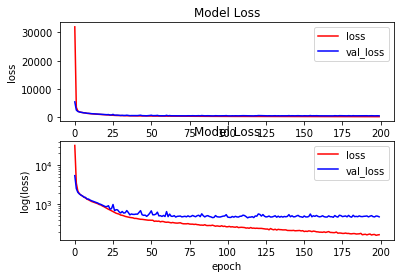

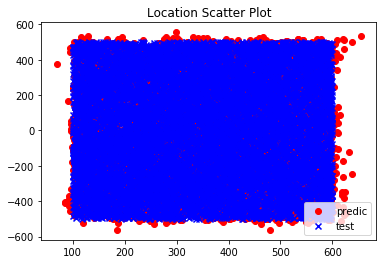

In [41]:
#plot the loss data
import math
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(212)
plt.semilogy(history.history['loss'],'r',label = 'loss')
plt.semilogy(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('Location Scatter Plot')
ax1.scatter(loc_prediction[:,0],loc_prediction[:,1],c = 'r',marker = 'o', label = 'predic')
ax1.scatter(location_test[:,0],location_test[:,1],c = 'b',marker = 'x', label = 'test')
plt.legend()
plt.show()

In [42]:
#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

10000/10000 [==============================] - 2s 244us/step
Test loss & mean_absolute_error:  485.4724998046875


error distance is  23.482750986149195
max error distance is  295.4854460929723
min error distance is  0.03997290523640328


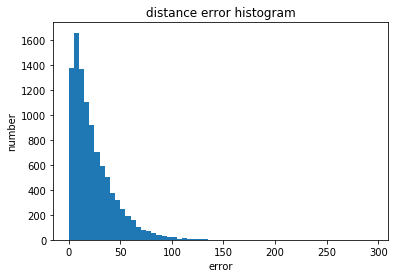

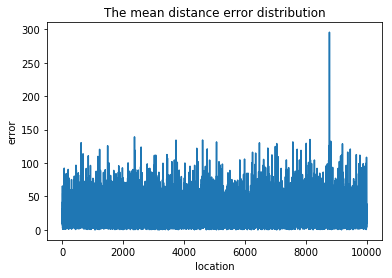

(10000, 1)

In [46]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(err_dis, bins =  range(0,300,5)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

plt.figure(2)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

Text(0.5, 0.92, 'The mean distance error of 3D Iamge')

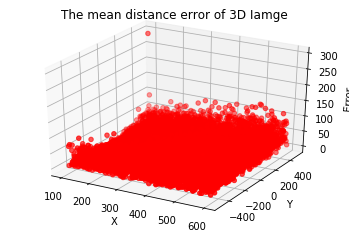

In [44]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

Text(0.5, 1.0, "The mean distance error of 'heat map'")

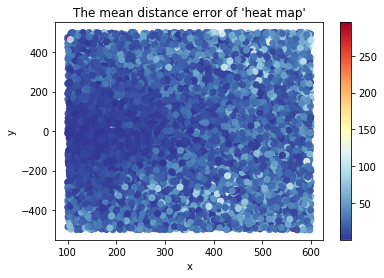

In [45]:
#draw the "heatmap" of error
fig = plt.figure()
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")